# 1.Setup

## 1.1 Install dependecies

In [1]:
!pip install tensorflow==2.4.1 opencv-python matplotlib

You should consider upgrading via the '/Users/sanjeev/Documents/faceid/faceid/bin/python3 -m pip install --upgrade pip' command.


## 1.2 Import dependencies

In [1]:
#standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#tensorflow dependencies- Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Create folder structure

In [3]:
#Setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [ ]:
#making directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. collect positive and anchor images

## 2.1 Untar labelled faces in the wild dataset

In [5]:
#uncompress tar gz labelled faces in the wild dataset
!tar -xf lfw.tgz

In [6]:
#Move lfw images to the following repository data/negative
for directory in os.listdir('lfw'):
   for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
       NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

## 2.2 Collect positive and anchor classes

In [7]:
#import uuid to generate unique image names
import uuid

In [10]:
# #establish a connection to the webcame
cap = cv2.VideoCapture(0)
while cap.isOpened():#loop through frames till the webcam is open
    ret,frame = cap.read() #read frames at every point in time
    
    frame = frame[130:130+250,530:530+250,:] #cut down frame to 250 X 250
    
    if cv2.waitKey(1) & 0XFF == ord('a'): #collecting anchor images
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) #create the unique file path
        cv2.imwrite(imgname, frame) #write out anchor image
        
    if cv2.waitKey(1) & 0XFF == ord('p'): #collecting positive images
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame) #rendering the frame back to the screen
    
    if cv2.waitKey(1) & 0XFF == ord('q'): #breaking
        break
        
cap.release() #release the webcam
cv2.destroyAllWindows() #close the image show frame

# 3. Load and preprocess images

## 3.1 Get image directories

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2022-05-10 00:39:36.240415: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-10 00:39:36.250581: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
dir_test.next()

b'data/anchor/0cef57c6-cc9e-11ec-8297-1094bbdfb49c.jpg'

## 3.2 Preprocess image - scale and resize

In [11]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) #read in image from file path
    img = tf.io.decode_jpeg(byte_img) #load in the image
    img = tf.image.resize(img,(100,100)) #resizing image to 100 X 100 X 3
    img = img / 255.0 #scaling the image between 0 and 1
    return img

## 3.3 Create labelled dataset

In [12]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [14]:
samples = data.as_numpy_iterator()

In [15]:
example = samples.next()

## 3.4 Create train and test split

In [16]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [17]:
res = preprocess_twin(*example)

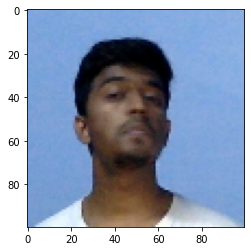

In [18]:
plt.imshow(res[0])

In [19]:
res[2]

1.0

In [20]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
len(samples.next())

2022-05-10 00:39:50.131413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


3

In [23]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model engineering

## 4.1 Build embedding layer 

In [25]:
inp = Input(shape=(100,100,3),name='input_image')

In [26]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [27]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)

In [28]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [29]:
m1 = MaxPooling2D(64,(2,2),padding='same')(c1)


In [30]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [31]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    
    #first block
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    #second block
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    #third block
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    
    #final embedding block
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)
    
    
    
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [32]:
embedding = make_embedding()

In [33]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build distance layer

In [34]:
#Siamese L1 distance class
class L1Dist(Layer):
    
    #init method - inheritance
    def __init__(self,**kwargs):
        super().__init__()
        
    # similarity calculation    
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Build siamese model

In [35]:
def make_siamese_model():
    
    #anchor image input
    input_image = Input(name = 'imput_img', shape = (100,100,3))
    
    #validation image input
    validation_image = Input(name = 'validation_img',shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    #classification layer
    classifier = Dense(1,activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image,validation_image],outputs= classifier,name = 'SiameseNetwork')

In [36]:
siamese_model = make_siamese_model()

In [37]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imput_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    imput_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# 5. Training

## 5.1 Setup loss and optimizer

In [38]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [39]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001


## 5.2 Establish checkpoints

In [40]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build train step function

In [41]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss
        

## 5.4 Build training loop

In [42]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [43]:
EPOCHS = 50

In [44]:
train(train_data,EPOCHS)

In [45]:
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist})

In [47]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [48]:
model.predict([test_input,test_val])

array([[9.9999982e-01],
       [6.4202049e-10],
       [2.0828709e-08],
       [3.4286791e-09],
       [2.9954034e-10],
       [9.9999976e-01],
       [2.9213620e-06],
       [9.9999928e-01],
       [3.9998636e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.4685343e-09],
       [1.4476519e-09],
       [1.0000000e+00],
       [1.0818222e-09]], dtype=float32)

In [49]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# verification function

In [52]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

#### some of the major steps were performed in colab notebook due to the inability of CPU to perform parallel tasks like training and further steps except the opencv real time verification

# OpenCV real time detection

In [53]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[130:130+250,530:530+250,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
False
False
True
True
